In [1]:
"""
Exp03C: Risk-off Gate Across Market Regimes

Goal:
- Examine how the risk-off gate behaves across different market regimes.
- Does it consistently improve downside control, or if its effectiveness is regime-dependent?


Fixed:
- Asset: SPY
- Signal: MA (same as Exp02 baseline, e.g., MA=80)
- Risk: vol_target - off
- thresholds = 0.15   # 年化阈值 (annualized)
- lookbacks  = 10


Sweep:
- Time slice (subsample)
Risk mode: no_gate vs risk_off_gate


Evaluation:
- Annual Return
- Sharpe Ratio
- Max Drawdown
- Equity curve & drawdown comparison (by regime)
- Gate activation frequency (qualitative)

"""

'\nExp03C: Risk-off Gate Across Market Regimes\n\nGoal:\n- Examine how the risk-off gate behaves across different market regimes.\n- Does it consistently improve downside control, or if its effectiveness is regime-dependent?\n\n\nFixed:\n- Asset: SPY\n- Signal: MA (same as Exp02 baseline, e.g., MA=80)\n- Risk: vol_target - off\n- thresholds = 0.15   # 年化阈值 (annualized)\n- lookbacks  = 10\n\n\nSweep:\n- Time slice (subsample)\nRisk mode: no_gate vs risk_off_gate\n\n\nEvaluation:\n- Annual Return\n- Sharpe Ratio\n- Max Drawdown\n- Equity curve & drawdown comparison (by regime)\n- Gate activation frequency (qualitative)\n\n'

In [2]:
import os
os.chdir("/Users/kim/Desktop/Quant-Research")
print(os.getcwd())

# os.chdir("..")
# print(os.getcwd())

/Users/kim/Desktop/Quant-Research


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from config import Config
from runner import run
from risk.risk_off_gate import risk_off_gate_vol

In [4]:
subsamples = {
    "2015-2017": ("2015-01-02", "2017-12-29"),   # post-GFC recovery / sideways
    "2018-2019": ("2018-01-02", "2019-12-31"),   # vol spikes + pre-covid
    "2020-2021": ("2020-01-02", "2021-12-31"),   # covid crash + QE bull
    "2022":      ("2022-01-03", "2022-12-30"),   # rate-hike bear
    "2023-2025": ("2023-01-03", "2025-01-03"),   # recent regime
    "full":      ("2015-01-02", "2025-01-03"),
}

In [10]:

### baseline:  config
from copy import deepcopy
from dataclasses import replace
cfg_base = replace(Config(), 
                   RISK_MODE="none", # # Exp03A: isolate gate effect (vol_target: off)
                   MA_WINDOW=80,   # 和Exp02同
                   GATE_VOL_THRESHOLD_ANNUAL=0.15,
                    GATE_LOOKBACK=10
                  )   

rows = []

for name, (start, end) in subsamples.items():
    cfg_regime = replace(cfg_base, START=start, END=end)

    for use_risk_off_gate in [False, True]:
        cfg_tmp = replace(cfg_regime, USE_RISK_OFF_GATE=use_risk_off_gate)

        _, s = run(cfg_tmp)

        s["subsample"] = name
        s["START"] = start
        s["END"] = end
        s["MA_WINDOW"] = cfg_tmp.MA_WINDOW
        s["USE_RISK_OFF_GATE"] = use_risk_off_gate

        rows.append(s)

exp03c = pd.DataFrame(rows)
exp03c


/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  idx = pd.to_datetime(df.index, errors="coerce")
/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed in

,Annual Return,Max Drawdown,Sharpe,Total Turnover,N_obs,subsample,START,END,MA_WINDOW,USE_RISK_OFF_GATE
0,0.066957,-0.118435,0.806350,26.0,675,2015-2017,2015-01-02,2017-12-29,80,False
1,0.064238,-0.110395,0.843016,28.0,675,2015-2017,2015-01-02,2017-12-29,80,True
2,0.040937,-0.149217,0.497173,21.0,423,2018-2019,2018-01-02,2019-12-31,80,False
3,0.082436,-0.076632,1.062824,9.0,423,2018-2019,2018-01-02,2019-12-31,80,True
4,0.255804,-0.102789,1.618033,13.0,425,2020-2021,2020-01-02,2021-12-31,80,False
5,0.110415,-0.090553,1.095699,24.0,425,2020-2021,2020-01-02,2021-12-31,80,True
6,-0.130156,-0.139461,-1.122844,11.0,171,2022,2022-01-03,2022-12-30,80,False
7,-0.012544,-0.037845,-0.240766,4.0,171,2022,2022-01-03,2022-12-30,80,True
8,0.196677,-0.085406,1.666605,10.0,422,2023-2025,2023-01-03,2025-01-03,80,False
9,0.142305,-0.086210,1.374202,23.0,422,2023-2025,2023-01-03,2025-01-03,80,True


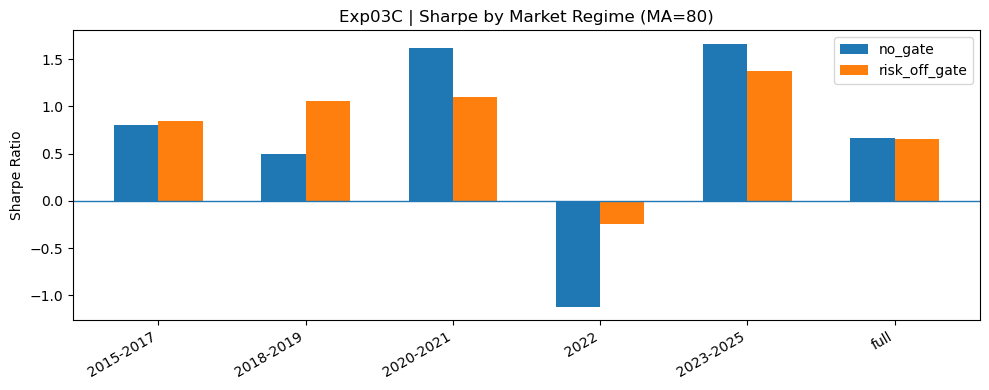

In [15]:
### Sharpe by Regime

import numpy as np
import matplotlib.pyplot as plt

# 确保顺序
order = ["2015-2017", "2018-2019", "2020-2021", "2022", "2023-2025", "full"]

pivot = exp03c.pivot(
    index="subsample",
    columns="USE_RISK_OFF_GATE",
    values="Sharpe"
).loc[order]

x = np.arange(len(pivot.index))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(x - width/2, pivot[False], width, label="no_gate")
ax.bar(x + width/2, pivot[True],  width, label="risk_off_gate")

ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=30, ha="right")
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Exp03C | Sharpe by Market Regime (MA=80)")
ax.axhline(0, linewidth=1)
ax.legend(framealpha=0.8)

plt.tight_layout()
plt.show()

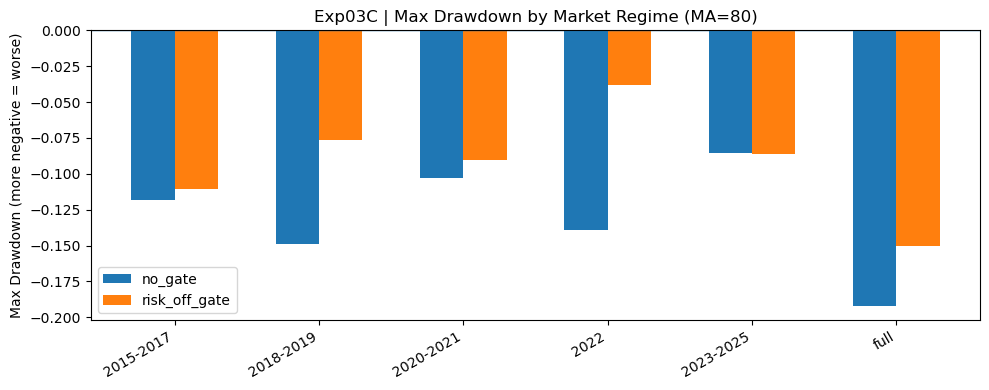

In [17]:
### Max Drawdown by Regime（同一风格）

pivot = exp03c.pivot(
    index="subsample",
    columns="USE_RISK_OFF_GATE",
    values="Max Drawdown"
).loc[order]

x = np.arange(len(pivot.index))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(x - width/2, pivot[False], width, label="no_gate")
ax.bar(x + width/2, pivot[True],  width, label="risk_off_gate")

ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=30, ha="right")
ax.set_ylabel("Max Drawdown (more negative = worse)")
ax.set_title("Exp03C | Max Drawdown by Market Regime (MA=80)")
ax.axhline(0, linewidth=1)
ax.legend(framealpha=0.8)

plt.tight_layout()
plt.show()
